In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)
sys.path.append(os.path.join(parent_folder_path, 'equities/data_processing'))

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


from pathlib import Path
from typing import Optional
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from decimal import Decimal

from equities.data_processing.lobster import lobster_preproc
from equities.data_processing import itch_preproc
from equities.data_processing.lobster import lobster_encoding
from equities.data_processing import itch_encoding
from equities.data_processing.lobster import lobster_dataloader
from equities.data_processing import itch_dataloader

Let's setup a few paths! For convenience, we will redirect all the output artefacts to the MarketSimT/artefacts directory—this includes processed dataset, tokenizer files, experimental artefacts (configs, saved checkpoints, trained models, etc.), etc.

In [3]:
# BASE_DIR = os.path.abspath(".")
# ARTEFACTS_DIR = os.path.join(BASE_DIR, "artefacts")
# SCRIPTS_DIR = os.path.join(BASE_DIR, "scripts")
# CONFIGS_DIR = os.path.join(BASE_DIR, "scripts/configs")

In [4]:
# !process_dataset.py \
#     --data_dir={os.path.join(parent_folder_path, "dataset/raw/ITCH/")} \
#     --save_dir={os.path.join(parent_folder_path, "dataset/ITCH/")} \
#     --filter_above_lvl=20 \
#     --n_tick_range=500

In [3]:
lobster_load_path = parent_folder_path + '/dataset/raw/LOBSTER/'
itch_load_path = parent_folder_path + '/dataset/raw/ITCH/'

# locate LOBSTER data
lobster_message_files = sorted(glob(lobster_load_path + '*message*.csv'))
lobster_book_files = sorted(glob(lobster_load_path + '*orderbook*.csv'))

print('found', len(lobster_message_files), 'LOBSTER message files')
print('found', len(lobster_book_files), 'LOBSTER book files')
print()

# locate ITCH data
itch_message_files = sorted(glob(itch_load_path + '*message*.csv'))
itch_book_files = sorted(glob(itch_load_path + '*book*.csv'))

print('found', len(itch_message_files), 'ITCH message files')
print('found', len(itch_book_files), 'ITCH book files')

found 1 LOBSTER message files
found 1 LOBSTER book files

found 8 ITCH message files
found 8 ITCH book files


In [6]:
# load LOBSTER data
for m_f, b_f in tqdm(zip(lobster_message_files, lobster_book_files)):
    print(m_f)
    print(b_f)

    lobster_messages = lobster_preproc.load_message_df(m_f)

    lobster_book = pd.read_csv(
        b_f,
        index_col=False,
        header=None
    )
    assert len(lobster_messages) == len(lobster_book)

    print("LOBSTER messages shape:", lobster_messages.shape)
    print("LOBSTER book shape:", lobster_book.shape)

# load ITCH data
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    if '03272019' not in m_f:
        continue

    print(m_f)
    print(b_f)

    itch_messages = itch_preproc.load_message_df(m_f)

    itch_book = pd.read_csv(
        b_f,
        # index_col=False,
        # header=None
    )
    assert len(itch_messages) == len(itch_book)

    print("ITCH messages shape:", itch_messages.shape)
    print("ITCH book shape:", itch_book.shape)

    # return first one only
    break

0it [00:00, ?it/s]

/home/aaron/Documents/Github/MarketSimT/dataset/raw/LOBSTER/AAPL_2012-06-21_34200000_57600000_message_10.csv
/home/aaron/Documents/Github/MarketSimT/dataset/raw/LOBSTER/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv


1it [00:00,  1.55it/s]


LOBSTER messages shape: (400391, 6)
LOBSTER book shape: (400391, 40)


0it [00:00, ?it/s]

/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/03272019.NASDAQ_ITCH50_AAPL_message.csv
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/03272019.NASDAQ_ITCH50_AAPL_book_20.csv


2it [00:04,  2.06s/it]

ITCH messages shape: (2010136, 12)
ITCH book shape: (2010136, 81)


In [7]:
# load symbols file
symbols_load_path = parent_folder_path + '/dataset/symbols/'
symbols_file = sorted(glob(symbols_load_path + '*sp500*.txt'))[0]

print(symbols_file)

# create symbol mapping
d = {}
with open(symbols_file) as f:
    idx = 0
    for line in f:
        idx += 1
        d[line.strip()] = idx

ticker = m_f.rsplit('/', maxsplit=1)[-1][:-12].rsplit('_', maxsplit=1)[-1]
ticker

/home/aaron/Documents/Github/MarketSimT/dataset/symbols/sp500_constituents_symbols_3_06_2023.txt


'AAPL'

### Message Processing

In [8]:
# lobster_messages
# # lobster_book

# # itch_messages
# # itch_book

In [9]:
# print("Columns:", list(lobster_messages.columns))
# print("Sample:", lobster_messages.values[1])
# print()

# lobster_tok = lobster_encoding.Message_Tokenizer()

# print('<< pre processing LOBSTER dataset >>')
# lobster_m_ = lobster_tok.preproc(lobster_messages, lobster_book)

# print("Shape:", lobster_m_.shape)
# print("Columns:", ['order_id', 'event_type', 'direction', 'price_abs', 'price', 'size',
#                'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns',
#                # ref fields
#                'price', 'size', 'time_s', 'time_ns'])
# print("Sample:", lobster_m_[0])
# lobster_m_

In [10]:
# # filter out only allowed event types ...
# allowed_event_types=[1,2,3,4]
# lobster_messages = lobster_messages.loc[lobster_messages.event_type.isin(allowed_event_types)].copy()
# # ... and corresponding book changes
# lobster_book = lobster_book.loc[lobster_messages.index]

# # TIME
# # DELTA_T: time since previous order --> 4 tokens of length 3
# lobster_messages.insert(
#     loc=1,
#     column='delta_t_ns',
#     value=lobster_messages['time'].diff().fillna(0)
# )
# lobster_messages.insert(
#     loc=1,
#     column='delta_t_s',
#     value=lobster_messages.delta_t_ns.astype(int)
# )
# lobster_messages.delta_t_ns = ((lobster_messages.delta_t_ns % 1) * 1000000000).astype(int)

# lobster_messages.insert(0, 'time_s', lobster_messages.time.astype(int))
# lobster_messages.rename(columns={'time': 'time_ns'}, inplace=True)
# lobster_messages.time_ns = ((lobster_messages.time_ns % 1) * 1000000000).astype(int)

# # SIZE
# lobster_messages.loc[lobster_messages['size'] > 9999, 'size'] = 9999
# lobster_messages['size'] = lobster_messages['size'].astype(int)

# # PRICE
# lobster_messages['price_abs'] = lobster_messages.price  # keep absolute price for later (simulator)
# # mid-price reference, rounded down to nearest tick_size
# tick_size = 100
# p_ref = ((lobster_book.iloc[:, 0] + lobster_book.iloc[:, 2]) / 2).shift()#.round(-2).astype(int).shift()
# p_ref = (p_ref // tick_size) * tick_size
# # --> 1999 price levels // ...00 since tick size is 100
# lobster_messages.price = lobster_tok._preproc_prices(lobster_messages.price, p_ref, p_lower_trunc=-99900, p_upper_trunc=99900)
# lobster_messages = lobster_messages.iloc[1:]
# lobster_messages.price = lobster_messages.price.astype(int)

# # DIRECTION
# lobster_messages.direction = ((lobster_messages.direction + 1) / 2).astype(int)

# # change column order
# lobster_messages = lobster_messages[['order_id', 'event_type', 'direction', 'price_abs', 'price', 'size',
#         'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns']]

# lobster_messages

In [11]:
# # add original message as feature
# # for all referential order types (2, 3, 4)
# modif_types={2,3,4}
# modif_fields=['price', 'size', 'time_s', 'time_ns']
# nan_val=-9999

# m_changes = pd.merge(
#     lobster_messages.loc[lobster_messages.event_type.isin(modif_types)].reset_index(),
#     lobster_messages.loc[lobster_messages.event_type == 1, ['order_id'] + modif_fields],
#     how='left', on='order_id', suffixes=['', '_ref']).set_index('index')

# # m_changes

# # add new empty columns for referenced order
# modif_cols = [field + '_ref' for field in modif_fields]
# lobster_messages[modif_cols] = nan_val

# # replace order changes by original order and additional new fields
# lobster_messages.loc[m_changes.index] = m_changes
# lobster_messages[modif_cols] = lobster_messages[modif_cols].fillna(nan_val).astype(int)

# lobster_messages

In [12]:
itch_messages

,time,type,id,side,size,price,cancSize,execSize,oldId,oldSize,oldPrice,mpid
0,14400006432545,A,13301,1,18.0,207.85,NaN,NaN,NaN,NaN,NaN,NaN
1,14400008777412,A,15969,0,100.0,129.33,NaN,NaN,NaN,NaN,NaN,NaN
2,14400016498868,A,20677,0,1.0,114.94,NaN,NaN,NaN,NaN,NaN,NaN
3,14400017857990,A,22061,0,1.0,98.39,NaN,NaN,NaN,NaN,NaN,NaN
4,14403597489791,A,98453,1,300.0,192.70,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2010131,72000073334596,D,336886329,0,0.0,186.45,100.0,NaN,NaN,NaN,NaN,NaN
2010132,72000073447563,D,342882157,0,0.0,188.00,1.0,NaN,NaN,NaN,NaN,NaN
2010133,72000073477970,D,335312241,0,0.0,175.00,50.0,NaN,NaN,NaN,NaN,NaN
2010134,72000074023439,D,343725045,1,0.0,195.00,2600.0,NaN,NaN,NaN,NaN,NaN


##### ITCH Pre-processing

In [13]:
# # filter messages that are above a certain level
# filter_above_lvl = 20
# # itch_book = itch_book.iloc[:, :filter_above_lvl * 4 + 1]
# itch_messages, itch_book = itch_preproc.filter_by_lvl(itch_messages, itch_book, filter_above_lvl)

# remove mpid field from ITCH data
itch_messages = itch_messages.drop(columns=['mpid'])

# remove pre-market and after-market hours from ITCH data
remove_premarket = False # True
remove_aftermarket = False # True

if remove_premarket:
    itch_messages = itch_messages[itch_messages['time'] >= 34200000000000]
if remove_aftermarket:
    itch_messages = itch_messages[itch_messages['time'] <= 57600000000000]

# itch_messages = itch_messages[itch_messages['time'] >= 34200000000000]
# itch_messages = itch_messages[itch_messages['time'] <= 57600000000000]

# format time for pre-processing
itch_messages['time'] = itch_messages['time'].astype('string')
itch_messages['time'] = itch_messages['time'].apply(lambda x: '.'.join((x[0:5], x[5:])))
itch_messages['time'] = itch_messages['time'].apply(lambda x: Decimal(x))

# convert price to pennies from dollars
itch_messages['price'] = (itch_messages['price'] * 100).astype('int')
itch_messages['oldPrice'] = (itch_messages['oldPrice'] * 100) # make int after dealing with NaNs

itch_messages

,time,type,id,side,size,price,cancSize,execSize,oldId,oldSize,oldPrice
0,14400.006432545,A,13301,1,18.0,20785,NaN,NaN,NaN,NaN,NaN
1,14400.008777412,A,15969,0,100.0,12933,NaN,NaN,NaN,NaN,NaN
2,14400.016498868,A,20677,0,1.0,11494,NaN,NaN,NaN,NaN,NaN
3,14400.017857990,A,22061,0,1.0,9839,NaN,NaN,NaN,NaN,NaN
4,14403.597489791,A,98453,1,300.0,19270,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2010131,72000.073334596,D,336886329,0,0.0,18645,100.0,NaN,NaN,NaN,NaN
2010132,72000.073447563,D,342882157,0,0.0,18800,1.0,NaN,NaN,NaN,NaN
2010133,72000.073477970,D,335312241,0,0.0,17500,50.0,NaN,NaN,NaN,NaN
2010134,72000.074023439,D,343725045,1,0.0,19500,2600.0,NaN,NaN,NaN,NaN


In [14]:
print("Columns:", list(itch_messages.columns))
print("Sample:", itch_messages.values[1])
print()

itch_tok = itch_encoding.Message_Tokenizer()

print('<< pre processing ITCH dataset >>')
itch_m_ = itch_tok.preproc(itch_messages, itch_book)

print("Shape:", itch_m_.shape)
# print("Columns:", ['id', 'type', 'side', 'price_abs', 'price', 'size',
#                'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns',
#                # ref fields
#                'cancSize', 'execSize', 'oldId', 'oldSize', 'oldPrice',
#                'time_s_ref', 'time_ns_ref'])

print("Columns:", ['id', 'type', 'side', 'price_abs', 'price', 'fill_size', 'remain_size', 
                'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns', 'old_id',
                # ref fields
                'price_ref', 'fill_size_ref', 'time_s_ref', 'time_ns_ref', 'old_price_abs'])

print("Sample:", itch_m_[0])
itch_m_

Columns: ['time', 'type', 'id', 'side', 'size', 'price', 'cancSize', 'execSize', 'oldId', 'oldSize', 'oldPrice']
Sample: [Decimal('14400.008777412') 'A' 15969 0 100.0 12933 nan nan nan nan nan]

<< pre processing ITCH dataset >>
truncating 1.8007% of prices > 999
truncating 1.6144% of prices < -999
Shape: (2003140, 17)
Columns: ['id', 'type', 'side', 'price_abs', 'price', 'fill_size', 'remain_size', 'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns', 'old_id', 'price_ref', 'fill_size_ref', 'time_s_ref', 'time_ns_ref', 'old_price_abs']
Sample: [  15969       1       0   12933     999     100   -9999       0 2344867
   14400 8777412   -9999   -9999   -9999   -9999   -9999   -9999]


/home/aaron/Documents/Github/MarketSimT/equities/data_processing/itch_encoding.py:475: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.type = m.type.replace({'A': 1, 'E': 2, 'C': 3, 'D': 4, 'R': 5})


array([[    15969,         1,         0, ...,     -9999,     -9999,
            -9999],
       [    20677,         1,         0, ...,     -9999,     -9999,
            -9999],
       [    22061,         1,         0, ...,     -9999,     -9999,
            -9999],
       ...,
       [335312241,         4,         0, ...,     56890, 566837429,
            -9999],
       [343725045,         4,         1, ...,     57309, 388685794,
            -9999],
       [353209329,         4,         1, ...,     57799, 533545153,
            -9999]])

In [15]:
# print(itch_m_.shape)
itch_m_

# prepend column with ticker ID
ticker_id = d[ticker]
itch_m_ = np.concatenate([np.full((itch_m_.shape[0], 1), ticker_id), itch_m_], axis=1)
print(itch_m_.shape)
itch_m_


(2003140, 18)


array([[       40,     15969,         1, ...,     -9999,     -9999,
            -9999],
       [       40,     20677,         1, ...,     -9999,     -9999,
            -9999],
       [       40,     22061,         1, ...,     -9999,     -9999,
            -9999],
       ...,
       [       40, 335312241,         4, ...,     56890, 566837429,
            -9999],
       [       40, 343725045,         4, ...,     57309, 388685794,
            -9999],
       [       40, 353209329,         4, ...,     57799, 533545153,
            -9999]])

In [29]:
# itch_tok = itch_encoding.Message_Tokenizer()

# # filter out only allowed event types ...
# allowed_event_types=['A','E','C','D','R']
# itch_messages = itch_messages.loc[itch_messages.type.isin(allowed_event_types)].copy()
# # ... and corresponding book changes
# itch_book = itch_book.loc[itch_messages.index]

# # TIME
# # DELTA_T: time since previous order --> 4 tokens of length 3
# itch_messages.insert(
#     loc=1,
#     column='delta_t_ns',
#     value=itch_messages['time'].diff().fillna(0)
# )
# itch_messages.insert(
#     loc=1,
#     column='delta_t_s',
#     value=itch_messages.delta_t_ns.astype(int)
# )
# itch_messages.delta_t_ns = ((itch_messages.delta_t_ns % 1) * 1000000000).astype(int)

# itch_messages.insert(0, 'time_s', itch_messages.time.astype(int))
# itch_messages.rename(columns={'time': 'time_ns'}, inplace=True)
# itch_messages.time_ns = ((itch_messages.time_ns % 1) * 1000000000).astype(int)

# # SIZE
# itch_messages.loc[itch_messages['size'] > 9999, 'size'] = 9999
# itch_messages.loc[itch_messages['oldSize'] > 9999, 'oldSize'] = 9999
# itch_messages.loc[itch_messages['execSize'] > 9999, 'execSize'] = 9999
# itch_messages.loc[itch_messages['cancSize'] > 9999, 'cancSize'] = 9999
# itch_messages['size'] = itch_messages['size'].astype(int) # cannot do this to all other size fields bc they may be NaN (handled later)
# # consolidate size columns
# itch_messages['remain_size'] = itch_messages['size']
# n_cols = len(itch_messages.columns)
# for i in range(0, len(itch_messages)):
#     # set remaining size of add order to NaN
#     if itch_messages['type'].iloc[i] == 'A':
#         itch_messages.iloc[i, (n_cols-1)] = itch_messages['execSize'].iloc[i] # NaN
#     # set fill size of execute and cancel orders to execSize and cancSize respectively
#     elif itch_messages['type'].iloc[i] == 'E':
#         itch_messages.iloc[i, 7] = itch_messages['execSize'].iloc[i]
#     elif itch_messages['type'].iloc[i] == 'C':
#         itch_messages.iloc[i, 7] = itch_messages['execSize'].iloc[i]
#     elif itch_messages['type'].iloc[i] == 'D':
#         itch_messages.iloc[i, 7] = itch_messages['cancSize'].iloc[i]
#     # set remaining size of replace order to NaN
#     elif itch_messages['type'].iloc[i] == 'R':
#         itch_messages.iloc[i, (n_cols-1)] = itch_messages['execSize'].iloc[i] # NaN
# itch_messages = itch_messages.rename(columns={'size': 'fill_size'})


# # PRICE
# itch_messages['price_abs'] = itch_messages.price  # keep absolute price for later (simulator)
# itch_messages['old_price_abs'] = itch_messages.oldPrice  # keep absolute old price for later (simulator)
# # mid-price reference, rounded down to nearest tick_size
# tick_size = 1
# p_ref = (((itch_book.iloc[:, 1] * 100) + (itch_book.iloc[:, 3] * 100)) / 2).shift()#.round(-2).astype(int).shift()
# p_ref = (p_ref // tick_size) * tick_size
# # --> 1999 price levels // ...00 since tick size is 100
# itch_messages.price = itch_tok._preproc_prices(itch_messages.price, p_ref, p_lower_trunc=-999, p_upper_trunc=999)
# itch_messages = itch_messages.iloc[1:]
# # itch_messages.price = itch_messages.price.astype(int)
# itch_messages.price = itch_messages.price.fillna(999).astype(int)

# # # DIRECTION
# # itch_messages.direction = ((itch_messages.direction + 1) / 2).astype(int)

# itch_messages

In [30]:
# # add time elements of original message as feature and process NaNs
# # for all referential order types ('E','C','D','R')
# modif_types={'E','C','D'}
# modif_types_special={'R'}
# modif_fields=['price', 'fill_size', 'time_s', 'time_ns']
# modif_fields_special=['price_abs', 'fill_size', 'time_s', 'time_ns']
# # ref_cols = ['cancSize', 'execSize', 'oldId', 'oldSize', 'oldPrice']
# special_cols = ['oldId', 'remain_size', 'old_price_abs']
# nan_val=-9999

# # make df that converts 'R' values to 'A' values so that we can reference add order component of replace orders
# itch_r_messages = itch_messages.copy()
# itch_r_messages['type'] = itch_r_messages['type'].replace('R', 'A')

# # find and merge modif_fields of E, C, D events that match with A (and R) event id
# m_changes = pd.merge(
#     itch_messages.loc[itch_messages.type.isin(modif_types)].reset_index(),
#     itch_r_messages.loc[itch_r_messages.type == 'A', ['id'] + modif_fields],
#     how='left', on='id', suffixes=['', '_ref']).set_index('index')

# m_changes

# # find modif_fields of R events that match with past A and R event oldIds
# m_changes_special = pd.merge(
#     itch_messages.loc[itch_messages.type.isin(modif_types_special)].reset_index(),
#     (itch_r_messages.loc[itch_r_messages.type == 'A', ['id'] + modif_fields_special]).rename(columns={'id': 'oldId'}),
#     how='left', on='oldId', suffixes=['', '_ref']).set_index('index')
# # price_ref = old_mid_price - new_mid_price (different from price_ref above)
# m_changes_special.rename(columns={'price_abs_ref': 'price_ref'}, inplace=True)
# m_changes_special['price_ref'] = m_changes_special['price_ref'] - m_changes_special['price_abs']

# m_changes_special

# # add new empty columns for referenced order
# modif_cols = [field + '_ref' for field in modif_fields]
# itch_messages[modif_cols] = nan_val

# # fill reference order types with new values
# itch_messages.loc[m_changes.index] = m_changes
# itch_messages.loc[m_changes_special.index] = m_changes_special
# itch_messages[modif_cols] = itch_messages[modif_cols].fillna(nan_val).astype(int)

# # prepare remaining columns for encoding stage (fill NaNs)
# itch_messages[special_cols] = itch_messages[special_cols].fillna(nan_val).astype(int)

# itch_messages

In [31]:
# # change column order
# itch_messages = itch_messages.rename(columns={'oldId': 'old_id'})
# itch_messages = itch_messages[['id', 'type', 'side', 'price_abs', 'price',
#         'fill_size', 'remain_size', 'delta_t_s', 'delta_t_ns', 'time_s', 'time_ns',
#         'old_id', 'price_ref', 'fill_size_ref', 'time_s_ref', 'time_ns_ref', 'old_price_abs']]

# # event_map = {
# #     'A': 1,
# #     'E': 2,
# #     'C': 3,
# #     'D': 4,
# #     'R': 5
# # }
# # itch_messages['type'] = itch_messages['type'].replace(event_map) 
# itch_messages.type = itch_messages.type.replace({'A': 1, 'E': 2, 'C': 3, 'D': 4, 'R': 5})
# itch_messages

### Book Processing

In [88]:
# load ITCH data
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    if '03272019' not in m_f:
        continue
    
    itch_messages = itch_preproc.load_message_df(m_f)

    itch_book = pd.read_csv(
        b_f,
        # index_col=False,
        # header=None
    )
    assert len(itch_messages) == len(itch_book)

    print("ITCH messages shape:", itch_messages.shape)
    print("ITCH book shape:", itch_book.shape)

# remove pre-market and after-market hours from ITCH data
if remove_premarket:
    itch_messages = itch_messages[itch_messages['time'] >= 34200000000000]
if remove_aftermarket:
    itch_messages = itch_messages[itch_messages['time'] <= 57600000000000]

print("ITCH messages shape 2:", itch_messages.shape)
print("ITCH book shape 2:", itch_book.shape)

# remove disallowed order types
allowed_events=['A','E','C','D','R']
itch_messages = itch_messages.loc[itch_messages.type.isin(allowed_events)]
# make sure book is same length as messages
itch_book = itch_book.loc[itch_messages.index]

print("ITCH messages shape 3:", itch_messages.shape)
print("ITCH book shape 3:", itch_book.shape)

# # filter messages that are above a certain level
# filter_above_lvl = 20
# itch_messages, itch_book = itch_preproc.filter_by_lvl(itch_messages, itch_book, filter_above_lvl)

print("ITCH messages shape 4:", itch_messages.shape)
print("ITCH book shape 4:", itch_book.shape)

# remove time field from ITCH book data
itch_book = itch_book.drop(columns=['time'])

assert len(itch_messages) == len(itch_book)
itch_book

1it [00:04,  4.11s/it]

ITCH messages shape: (2010136, 12)
ITCH book shape: (2010136, 81)
ITCH messages shape 2: (2010136, 12)
ITCH book shape 2: (2010136, 81)


ITCH messages shape 3: (2003141, 12)
ITCH book shape 3: (2003141, 81)
ITCH messages shape 4: (2003141, 12)
ITCH book shape 4: (2003141, 81)


,1_bid_price,1_bid_vol,1_ask_price,1_ask_vol,2_bid_price,2_bid_vol,2_ask_price,2_ask_vol,3_bid_price,3_bid_vol,...,18_ask_price,18_ask_vol,19_bid_price,19_bid_vol,19_ask_price,19_ask_vol,20_bid_price,20_bid_vol,20_ask_price,20_ask_vol
0,NaN,NaN,207.85,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,129.33,100.0,207.85,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,129.33,100.0,207.85,18.0,114.94,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,129.33,100.0,207.85,18.0,114.94,1.0,NaN,NaN,98.39,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,129.33,100.0,192.70,300.0,114.94,1.0,207.85,18.0,98.39,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010131,188.00,1.0,188.99,1000.0,175.00,50.0,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010132,175.00,50.0,188.99,1000.0,NaN,NaN,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010133,NaN,NaN,188.99,1000.0,NaN,NaN,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010134,NaN,NaN,188.99,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# itch_messages
# lobster_book

In [ ]:
# # process book
# price_levels = 500 # n_price_series

# # mid-price rounded to nearest tick (100)
# p_ref = ((lobster_book.iloc[:, 0] + lobster_book.iloc[:, 2]) / 2).round(-2).astype(int)
# b_indices = lobster_book.iloc[:, ::2].sub(p_ref, axis=0).div(100).astype(int) # div 100 bc tick
# b_indices = b_indices + price_levels // 2 # make fit between span of 0 to price_levels
# b_indices.columns = list(range(b_indices.shape[1])) # reset col indices
# vol_book = lobster_book.iloc[:, 1::2].copy()
# # convert sell volumes (ask side) to negative
# vol_book.iloc[:, ::2] = vol_book.iloc[:, ::2].mul(-1)
# vol_book.columns = list(range(vol_book.shape[1])) # reset col indices

# # convert to book representation with volume at each price level relative to reference price (mid)
# # whilst preserving empty levels to maintain sparse representation of book
# # i.e. at each time we have a fixed width snapshot around the mid price
# # therefore movement of the mid price needs to be a separate feature (e.g. relative to previous price)

# mybook = np.zeros((len(lobster_book), price_levels), dtype=np.int32)

# a = b_indices.values
# for i in range(a.shape[0]):
#     for j in range(a.shape[1]):
#         price = a[i, j]
#         # remove prices outside of price_levels range
#         if price >= 0 and price < price_levels:
#             mybook[i, price] = vol_book.values[i, j]

# # prepend column with best bid changes (in ticks)
# mid_diff = p_ref.div(100).diff().fillna(0).astype(int).values
# mybook = np.concatenate([mid_diff[:, None], mybook], axis=1)

# mybook

In [65]:
itch_messages
itch_book

,1_bid_price,1_bid_vol,1_ask_price,1_ask_vol,2_bid_price,2_bid_vol,2_ask_price,2_ask_vol,3_bid_price,3_bid_vol,...,18_ask_price,18_ask_vol,19_bid_price,19_bid_vol,19_ask_price,19_ask_vol,20_bid_price,20_bid_vol,20_ask_price,20_ask_vol
0,NaN,NaN,207.85,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,129.33,100.0,207.85,18.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,129.33,100.0,207.85,18.0,114.94,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,129.33,100.0,207.85,18.0,114.94,1.0,NaN,NaN,98.39,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,129.33,100.0,192.70,300.0,114.94,1.0,207.85,18.0,98.39,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010131,188.00,1.0,188.99,1000.0,175.00,50.0,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010132,175.00,50.0,188.99,1000.0,NaN,NaN,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010133,NaN,NaN,188.99,1000.0,NaN,NaN,195.00,2600.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010134,NaN,NaN,188.99,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# # process book
# price_levels = 500 # n_price_series

# # mid-price rounded to nearest tick
# # p_ref = ((itch_book.iloc[:, 0] + itch_book.iloc[:, 2]) / 2).mul(100).round().astype(int)
# p_ref = ((itch_book.iloc[:, 0] + itch_book.iloc[:, 2]) / 2)
# # determine if NaN is present
# if p_ref.isnull().values.any():
#     print('NaN detected. Replacing with best existing bid or ask price.')
#     # replace mid-price with best existing bid or ask price
#     p_ref = p_ref.fillna(itch_book.iloc[:, 0].combine_first(itch_book.iloc[:, 2]))
#     # replace any remaining NaNs with previous value
#     if p_ref.isnull().values.any():
#         print('More NaN detected. Replacing with previous value.')
#         p_ref = p_ref.ffill()
# p_ref = p_ref.mul(100).round().astype(int) # format; round to nearest tick
# # how far are bid and ask from mid price?
# b_indices = itch_book.iloc[:, ::2].mul(100).fillna(0).sub(p_ref, axis=0).astype(int)
# b_indices = b_indices + price_levels // 2 # valid tick differences will fit between span of 0 to price_levels
# b_indices.columns = list(range(b_indices.shape[1])) # reset col indices
# vol_book = itch_book.iloc[:, 1::2].copy().fillna(0).astype(int)
# # convert sell volumes (ask side) to negative
# vol_book.iloc[:, 1::2] = vol_book.iloc[:, 1::2].mul(-1)
# vol_book.columns = list(range(vol_book.shape[1])) # reset col indices

# # convert to book representation with volume at each price level relative to reference price (mid)
# # whilst preserving empty levels to maintain sparse representation of book
# # i.e. at each time we have a fixed width snapshot around the mid price
# # therefore movement of the mid price needs to be a separate feature (e.g. relative to previous price)

# mybook = np.zeros((len(itch_book), price_levels), dtype=np.int32)

# a = b_indices.values
# for i in range(a.shape[0]):
#     for j in range(a.shape[1]):
#         price = a[i, j]
#         # remove prices outside of price_levels range
#         if price >= 0 and price < price_levels:
#             mybook[i, price] = vol_book.values[i, j]

# # prepend column with best bid changes (in ticks)
# mid_diff = p_ref.diff().fillna(0).astype(int).values
# mybook = np.concatenate([mid_diff[:, None], mybook], axis=1)

# mybook

In [89]:
mybook = itch_preproc.process_book(itch_book, price_levels=500)
mybook

NaN detected. Replacing with best existing bid or ask price.
More NaN detected. Replacing with previous value.


array([[    0,     0,     0, ...,     0,     0,     0],
       [-3926,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       ...,
       [  699,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]])

In [19]:
print(mybook.shape)

# prepend column with ticker ID
ticker_id = d[ticker]
mybook = np.concatenate([np.full((mybook.shape[0], 1), ticker_id), mybook], axis=1)
mybook

(1720464, 501)


array([[40,  0,  0, ...,  0,  0,  0],
       [40, -8,  0, ...,  0,  0,  0],
       [40, -2,  0, ...,  0,  0,  0],
       ...,
       [40,  0,  0, ...,  0,  0,  0],
       [40,  0,  0, ...,  0,  0,  0],
       [40,  1,  0, ...,  0,  0,  0]])

### Advanced Dataloading

##### LOBSTER Dataloading

In [1]:
# # Set params...
# msg_seq_len = 500
# use_book_data = True # False
# # use_simple_book = False
# # book_transform = True # False

# data_dir = parent_folder_path + '/dataset/proc/LOBSTER/'
# name = 'lobster'

# dataset_obj = lobster_dataloader.LOBSTER(
#     name,
#     data_dir=data_dir,
#     mask_fn=lobster_dataloader.LOBSTER_Dataset.causal_mask,
#     msg_seq_len=msg_seq_len,
#     use_book_data=use_book_data,
#     # use_simple_book=use_simple_book,
#     # book_transform=book_transform,
#     # book_depth=book_depth,
#     # n_cache_files=1e7,  # large number to keep everything in cache
#     # return_raw_msgs=return_raw_msgs,
# )
# dataset_obj.setup()

In [2]:
# vars(dataset_obj)

In [3]:
# from equities.data_processing.base import make_data_loader

# bsz = 16
# # use sampler to only get individual samples and automatic batching from dataloader
# trn_loader = make_data_loader(
#     dataset_obj.dataset_train,
#     dataset_obj,
#     seed=dataset_obj.seed,
#     batch_size=bsz)

# trn_loader

In [4]:
# # loop over batches...
# for batch_idx, batch in enumerate(tqdm(trn_loader)):
#     print("batch_idx:", batch_idx)
#     # print("batch:", batch)
#     print("len(batch):", len(batch))
#     inputs, targets, aux_data = batch
#     book_data = aux_data.get("book_data", None)
#     timestep_msg = aux_data.get("timesteps_msg", None) # None
#     timestep_book = aux_data.get("timesteps_book", None) # None
#     print("inputs.shape:", inputs.shape) # (bsz, 22*seq_len)
#     print("targets.shape:", targets.shape) # (bsz, 1)
#     print("book_data.shape:", book_data.shape) # (bsz, seq_len, 𝑃 + 1)
#     print("inputs:", inputs) # 22 tokens per message
#     print("targets:", targets) # prediction target is masked token?

#     # 𝑃 separate volume features around the mid-price, coupled with one feature
#     # representing mid-price changes from the previous observation.
#     print("book_data:", book_data) # book snapshots or "volume images"

#     break

In [5]:
# vocab = lobster_encoding.Vocab()
# vocab.ENCODING

# for i in inputs[0][0:22]:
#     print(i)
# inputs[0][0:22]
# print(lobster_encoding.decode_msg(inputs[0][0:22], vocab.ENCODING))

In [6]:
# lobster_tok = lobster_encoding.Message_Tokenizer()

# vars(lobster_tok)

# lobster_tok.FIELD_I

In [7]:
# X = np.load(dataset_obj.train_files[0], mmap_mode='r')
# X_raw = np.array(X[0:500])
# print(X_raw.shape)

# X_raw

# X = lobster_encoding.encode_msgs(X_raw, vocab.ENCODING)

# X

# # seq = X_raw.copy()
# seq = X.copy()

# y = seq[-1][11]
# y

# seq[-1][11] = -10000

# seq

# y = y.reshape(-1)
# X = X.reshape(-1)
# X

##### ITCH Dataloading

In [1]:
# Set params...
msg_seq_len = 500
use_book_data = True # False
# use_simple_book = False
# book_transform = True # False

data_dir = parent_folder_path + '/dataset/proc/ITCH/'
name = 'itch'

dataset_obj = itch_dataloader.ITCH(
    name,
    data_dir=data_dir,
    mask_fn=itch_dataloader.ITCH_Dataset.causal_mask,
    msg_seq_len=msg_seq_len,
    use_book_data=use_book_data,
    # use_simple_book=use_simple_book,
    # book_transform=book_transform,
    # book_depth=book_depth,
    # n_cache_files=1e7,  # large number to keep everything in cache
    # return_raw_msgs=return_raw_msgs,
)
dataset_obj.setup()

vars(dataset_obj)

In [5]:
from equities.data_processing.base import make_data_loader

bsz = 16
# use sampler to only get individual samples and automatic batching from dataloader
trn_loader = make_data_loader(
    dataset_obj.dataset_train,
    dataset_obj,
    seed=dataset_obj.seed,
    batch_size=bsz)

trn_loader

In [6]:
# loop over batches...
for batch_idx, batch in enumerate(tqdm(trn_loader)):
    print("batch_idx:", batch_idx)
    # print("batch:", batch)
    print("len(batch):", len(batch))
    inputs, targets, aux_data = batch
    book_data = aux_data.get("book_data", None)
    timestep_msg = aux_data.get("timesteps_msg", None) # None
    timestep_book = aux_data.get("timesteps_book", None) # None
    print("inputs.shape:", inputs.shape) # (bsz, 25*seq_len)
    print("targets.shape:", targets.shape) # (bsz, 1)
    print("book_data.shape:", book_data.shape) # (bsz, seq_len, 𝑃 + 1)
    print("inputs:", inputs) # 25 tokens per message
    print("targets:", targets) # prediction target is masked token?

    # somewhere in last message of 500 length sequence, a token is masked
    # and becomes prediction target

    # 𝑃 separate volume features around the mid-price, coupled with one feature
    # representing mid-price changes from the previous observation.
    print("book_data:", book_data) # book snapshots or "volume images"

    break

  0%|          | 0/244 [00:01<?, ?it/s]

batch_idx: 0
len(batch): 3
inputs.shape: (16, 12500)
targets.shape: (16, 1)
book_data.shape: (16, 500, 502)
inputs: [[12051  1007 12011 ...   954   234     0]
 [12051  1006 12010 ...     2     0     1]
 [12051  1006 12011 ...     1     1     1]
 ...
 [12051  1003 12011 ...     1     1     1]
 [12051  1003 12010 ...     1     1     1]
 [12051  1007 12010 ...     1     1     1]]
targets: [[  787]
 [    2]
 [ 1008]
 [    3]
 [    2]
 [11010]
 [12051]
 [    3]
 [12010]
 [    2]
 [    2]
 [11010]
 [  566]
 [12010]
 [12009]
 [ 1003]]
book_data: [[[40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  ...
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]]

 [[40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  ...
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]]

 [[40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  0  0  0]
  ...
  [40  0  0 ...  0  0  0]
  [40  0  0 ...  

In [16]:
# for i in inputs[0][0:25]:
#     print(i)
# inputs[0][0:25] # first message
inputs[2][-25:] # last message
# print(itch_encoding.decode_msg(inputs[0][0:25], vocab.ENCODING))

array([12051,  1006, 12010, 12008, 11013,     0,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1], dtype=int32)

##### ITCH Encoding

In [4]:
dataset = '03272019.NASDAQ_ITCH50_AAPL_message_proc.npy'
data_dir = os.path.join('dataset/proc/ITCH/', dataset)
data_dir = parent_folder_path + '/' + data_dir

vocab = itch_encoding.Vocab()
itch_tok = itch_encoding.Message_Tokenizer()

itch_tok.FIELD_I

{'ticker': 0,
 'type': 1,
 'side': 2,
 'price': 3,
 'fill_size': 4,
 'remain_size': 5,
 'delta_t_s': 6,
 'delta_t_ns': 7,
 'time_s': 8,
 'time_ns': 9,
 'price_ref': 10,
 'fill_size_ref': 11,
 'time_s_ref': 12,
 'time_ns_ref': 13}

In [29]:
# X = np.load(dataset_obj.train_files[0], mmap_mode='r')
X = np.load(data_dir, mmap_mode='r')
X_raw = np.array(X[0:500])
print("X_raw.shape:", X_raw.shape)
print("X_raw:", X_raw)

X = itch_encoding.encode_msgs(X_raw, vocab.ENCODING)
print("X.shape:", X.shape)
print("X:", X)

# # seq = X_raw.copy()
# seq = X.copy()

# y = seq[-1][11]
# y

# seq[-1][11] = -10000

# seq

# y = y.reshape(-1)
# X = X.reshape(-1)
# X

sample = random.choice(X)
print("encoded sample:", sample)
print("decoded sample:", itch_encoding.decode_msg(sample, vocab.ENCODING))

X_raw.shape: (500, 18)
X_raw: [[     40 9449417       1 ...   -9999   -9999   -9999]
 [     40 9449521       1 ...   -9999   -9999   -9999]
 [     40 9460301       1 ...   -9999   -9999   -9999]
 ...
 [     40 9998365       1 ...   -9999   -9999   -9999]
 [     40 9998821       1 ...   -9999   -9999   -9999]
 [     40 9998845       1 ...   -9999   -9999   -9999]]
X.shape: (500, 24)
X: [[12051  1003 12010 ...     2     2     2]
 [12051  1003 12011 ...     2     2     2]
 [12051  1003 12011 ...     2     2     2]
 ...
 [12051  1003 12010 ...     2     2     2]
 [12051  1003 12010 ...     2     2     2]
 [12051  1003 12010 ...     2     2     2]]
encoded sample: [12051  1003 12011 12009 11245  1088     2     3     3    10   643    37
   203   955   543   393     2     2     2     2     2     2     2     2]
decoded sample: [       40     -9999         1         1     -9999       237        80
     -9999         0      7640     34200 952540390     -9999     -9999
     -9999     -9999     -9

In [9]:
vocab.ENCODING

{'time': (array([-10000, -20000,  -9999, ...,    997,    998,    999], dtype=int32),
  array([   0,    1,    2, ..., 1000, 1001, 1002], dtype=int32)),
 'type': (array([-10000, -20000,  -9999,      1,      2,      3,      4,      5],
        dtype=int32),
  array([   0,    1,    2, 1003, 1004, 1005, 1006, 1007], dtype=int32)),
 'size': (array([-10000, -20000,  -9999, ...,   9997,   9998,   9999], dtype=int32),
  array([    0,     1,     2, ..., 11005, 11006, 11007], dtype=int32)),
 'price': (array([-10000, -20000,  -9999, ...,    997,    998,    999], dtype=int32),
  array([    0,     1,     2, ..., 12005, 12006, 12007], dtype=int32)),
 'sign': (array([-10000, -20000,  -9999,     -1,      1], dtype=int32),
  array([    0,     1,     2, 12008, 12009], dtype=int32)),
 'side': (array([-10000, -20000,  -9999,      0,      1], dtype=int32),
  array([    0,     1,     2, 12010, 12011], dtype=int32)),
 'ticker': (array([-10000, -20000,  -9999,      1,      2,      3,      4,      5,
          

### Training

In [4]:
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import torch
from contextlib import nullcontext

from equities.model import GPTConfig, GPT

device = 'cuda' #torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


device

'cuda'

In [5]:
# determine appropriate msg_seq_len for efficient block_size
msg_seqL = 0
# for i in range(1, 500):
for i in range(1, 500):
    msg_seqL = i
    blk_size = msg_seqL*24 - 1 # minus 1 for target rescaling
    if msg_seqL % 24 == 0:
    # if blk_size % 64 == 0 and msg_seqL % 24 == 0:
        print(f"msg_seqL: {msg_seqL}, blk_size: {blk_size}")

msg_seqL: 24, blk_size: 575
msg_seqL: 48, blk_size: 1151
msg_seqL: 72, blk_size: 1727
msg_seqL: 96, blk_size: 2303
msg_seqL: 120, blk_size: 2879
msg_seqL: 144, blk_size: 3455
msg_seqL: 168, blk_size: 4031
msg_seqL: 192, blk_size: 4607
msg_seqL: 216, blk_size: 5183
msg_seqL: 240, blk_size: 5759
msg_seqL: 264, blk_size: 6335
msg_seqL: 288, blk_size: 6911
msg_seqL: 312, blk_size: 7487
msg_seqL: 336, blk_size: 8063
msg_seqL: 360, blk_size: 8639
msg_seqL: 384, blk_size: 9215
msg_seqL: 408, blk_size: 9791
msg_seqL: 432, blk_size: 10367
msg_seqL: 456, blk_size: 10943
msg_seqL: 480, blk_size: 11519


In [6]:
train_data_dir = parent_folder_path + '/dataset/proc/ITCH/train/'
train_message_files = sorted(glob(str(train_data_dir) + '/*message*.npy'))
assert len(train_message_files) > 0, f'no message files found in {train_data_dir}'

val_data_dir = parent_folder_path + '/dataset/proc/ITCH/val/'
val_message_files = sorted(glob(str(val_data_dir) + '/*message*.npy'))
assert len(val_message_files) > 0, f'no message files found in {val_data_dir}'

test_data_dir = parent_folder_path + '/dataset/proc/ITCH/test/'
test_message_files = sorted(glob(str(test_data_dir) + '/*message*.npy'))
assert len(test_message_files) > 0, f'no message files found in {test_data_dir}'

print("len(train_message_files):", len(train_message_files))
print("len(val_message_files):", len(val_message_files))
print("len(test_message_files):", len(test_message_files))

len(train_message_files): 6
len(val_message_files): 1
len(test_message_files): 1


In [7]:
# set seed
seed = 42
rng = random.Random(seed)

# load a list with all the train message files
train_datasets = []
for file in train_message_files:
    train_datasets.append(np.load(file, mmap_mode='r'))

# load a list with all the val message files
val_datasets = []
for file in val_message_files:
    val_datasets.append(np.load(file, mmap_mode='r'))

# load a list with all the test message files
test_datasets = []
for file in test_message_files:
    test_datasets.append(np.load(file, mmap_mode='r'))

train_datasets

[memmap([[       40,   9795465,         4, ...,     -9999,     -9999,
              -9999],
         [       40,   9806105,         1, ...,     -9999,     -9999,
              -9999],
         [       40,   9806141,         1, ...,     -9999,     -9999,
              -9999],
         ...,
         [       40, 327992593,         5, ...,     57599, 961935496,
              16027],
         [       40, 327992597,         1, ...,     -9999,     -9999,
              -9999],
         [       40, 327992857,         5, ...,     57599, 981953005,
              16528]]),
 memmap([[       40,  10134653,         1, ...,     -9999,     -9999,
              -9999],
         [       40,  10140325,         1, ...,     -9999,     -9999,
              -9999],
         [       40,  10140337,         1, ...,     -9999,     -9999,
              -9999],
         ...,
         [       40, 387932841,         1, ...,     -9999,     -9999,
              -9999],
         [       40, 387932961,         5, ...,   

In [8]:
# print shape of each dataset in train_datasets
for dataset in train_datasets:
    print(dataset.shape)

(1586524, 18)
(1942488, 18)
(1953936, 18)
(1206471, 18)
(727346, 18)
(1388800, 18)


In [8]:
# dataset = '03272019.NASDAQ_ITCH50_AAPL_book_20_proc.npy'
# data_dir = os.path.join('dataset/proc/ITCH/', dataset)
# data_dir = parent_folder_path + '/' + data_dir
# data_dir

# train_data = np.load(data_dir, mmap_mode='r')
# val_data = None

In [9]:
sample_dataset = rng.choice(train_datasets)
print("train_data.shape:", sample_dataset.shape)
vocab = itch_encoding.Vocab()
itch_tok = itch_encoding.Message_Tokenizer()
msg_seq_len = 432 # 425
batch_size = 2 # 8 # 16
# use_sink = False # True
use_sink = True

sample_dataset

train_data.shape: (1388800, 18)


memmap([[       40,   8963989,         1, ...,     -9999,     -9999,
             -9999],
        [       40,   8963993,         1, ...,     -9999,     -9999,
             -9999],
        [       40,   8964509,         1, ...,     -9999,     -9999,
             -9999],
        ...,
        [       40, 457803949,         4, ...,     57599, 941429324,
             -9999],
        [       40, 457814049,         1, ...,     -9999,     -9999,
             -9999],
        [       40, 457814741,         5, ...,     57599, 989131315,
             15621]])

In [44]:
# determine efficient vocab size
vocab_size = len(vocab)
print(f"vocab_size: {vocab_size}")
for i in range(len(vocab), (len(vocab) + 100)):
    vocab_size += 1
    if vocab_size % 64 == 0:
        print(f"vocab_size: {vocab_size}")

vocab_size: 12515
vocab_size: 12544
vocab_size: 12608


In [45]:
# poor man's data loader
def get_batch(split):
    datasets = train_datasets if split == 'train' else val_datasets
    data = rng.choice(datasets)
    print("train_data.shape:", data.shape)
    ix = torch.randint(len(data) - msg_seq_len, (batch_size,))
    # x = torch.stack([torch.from_numpy((data[i:i+msg_seq_len]).astype(np.int64)) for i in ix])
    x = torch.stack([torch.from_numpy((itch_encoding.encode_msgs((data[i:i+msg_seq_len]).astype(np.int64), vocab.ENCODING)).reshape(-1)) for i in ix])
    # y = torch.stack([torch.from_numpy((data[i+1:i+1+msg_seq_len]).astype(np.int64)) for i in ix])
    if use_sink:
        # append sink token to start of each batch sequence
        # **since vocab.SINK_TOK = 1, we can just use torch.ones
        x = torch.cat([torch.ones((batch_size, 1), dtype=torch.int), x], dim=1)
    y = x[:, 1:] # remove the first element of each batch
    y = y.type(torch.LongTensor) # casting to long
    x = x[:, :-1] # remove the last element of each batch
    
    # if device_type == 'cuda':
    #     # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
    #     x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    # else:
    #     x, y = x.to(device), y.to(device)
    x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    # x, y = x.to(device), y.to(device)
    return x, y

In [46]:
X, Y = get_batch('train') # fetch the very first batch
print("X.shape:", X.shape) # (batch_size, block_size)
print("Y.shape:", Y.shape)

X

train_data.shape: (727346, 18)
X.shape: torch.Size([2, 10368])
Y.shape: torch.Size([2, 10368])


tensor([[    1, 12051,  1006,  ...,     2,     2,     2],
        [    1, 12051,  1007,  ...,   273,   833,   360]], device='cuda:0',
       dtype=torch.int32)

In [48]:
print(vocab.SINK_TOK)
assert vocab.SINK_TOK == 1
torch.ones((batch_size, 1), dtype=torch.long, device=device) * vocab.SINK_TOK

torch.cat([torch.ones((batch_size, 1), dtype=torch.long, device=device), X], dim=1)
# torch.cat([X, torch.ones(batch_size, 1)], dim=1)
# torch.cat([])

1


tensor([[    1,     1, 12051,  ...,     2,     2,     2],
        [    1,     1, 12051,  ...,   273,   833,   360]], device='cuda:0')

In [49]:
block_size = X.shape[1] # real block_size; i.e., context length
print("block_size:", block_size)
Y

block_size: 10368


tensor([[12051,  1006, 12010,  ...,     2,     2,     2],
        [12051,  1007, 12010,  ...,   833,   360,   514]], device='cuda:0')

In [59]:
Y[0][-24:] # last message

tensor([12051,  1003, 12011, 12009, 11010,  1108,     2,     3,     3,    19,
          808,    59,   974,    53,   148,   348,     2,     2,     2,     2,
            2,     2,     2,     2], device='cuda:0')

In [58]:
X[0][-23:] # last message minus last token

tensor([12051,  1003, 12011, 12009, 11010,  1108,     2,     3,     3,    19,
          808,    59,   974,    53,   148,   348,     2,     2,     2,     2,
            2,     2,     2], device='cuda:0', dtype=torch.int32)

In [60]:
gptconf = GPTConfig()
# gptconf = GPTConfig(block_size=block_size,)

vars(gptconf)

{'block_size': 10367,
 'vocab_size': 12515,
 'n_layer': 12,
 'n_head': 12,
 'n_embd': 768,
 'dropout': 0.0,
 'bias': True}

In [61]:
model = GPT(gptconf)
model.to(device)

number of parameters: 94.67M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(12515, 768)
    (wpe): Embedding(10367, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=12515, bias=False)
)

In [62]:
model.eval()

# test forward pass
with ctx:
    logits, loss = model(X, Y)

print("logits.shape:", logits.shape)
print("loss:", loss)

logits.shape: torch.Size([1, 10367, 12515])
loss: tensor(9.5431, device='cuda:0', grad_fn=<NllLossBackward0>)


#### What is Optimal Block Size?

How far back in the message sequence does the average reference order refer back to?

In [68]:
# load ITCH data
messages_list = []
data_id_list = []
for m_f, b_f in tqdm(zip(itch_message_files, itch_book_files)):
    print(m_f)
    # print(b_f)
    date = m_f.rsplit('/', maxsplit=1)[-1][:8]
    sym = m_f.rsplit('/', maxsplit=1)[-1][:-12].rsplit('_', maxsplit=1)[-1]

    itch_messages = itch_preproc.load_message_df(m_f)

    # itch_book = pd.read_csv(
    #     b_f,
    #     # index_col=False,
    #     # header=None
    # )
    # assert len(itch_messages) == len(itch_book)

    # remove mpid field from ITCH data
    itch_messages = itch_messages.drop(columns=['mpid'])

    # # remove pre-market and after-market hours from ITCH data
    # remove_premarket = False # True
    # remove_aftermarket = False # True
    # if remove_premarket:
    #     itch_messages = itch_messages[itch_messages['time'] >= 34200000000000]
    # if remove_aftermarket:
    #     itch_messages = itch_messages[itch_messages['time'] <= 57600000000000]

    itch_messages = itch_messages[itch_messages['time'] >= 34200000000000]
    itch_messages = itch_messages[itch_messages['time'] <= 57600000000000]

    # # format time for pre-processing
    # itch_messages['time'] = itch_messages['time'].astype('string')
    # itch_messages['time'] = itch_messages['time'].apply(lambda x: '.'.join((x[0:5], x[5:])))
    # itch_messages['time'] = itch_messages['time'].apply(lambda x: Decimal(x))

    # convert price to pennies from dollars
    itch_messages['price'] = (itch_messages['price'] * 100).astype('int')
    itch_messages['oldPrice'] = (itch_messages['oldPrice'] * 100) # make int after dealing with NaNs

    # append message index to front of dataframe
    itch_messages.insert(
        loc=0,
        column='msg_idx',
        value=itch_messages.axes[0].tolist()
    )

    print("ITCH messages shape:", itch_messages.shape)
    # print("ITCH book shape:", itch_book.shape)
    

    # append to list
    messages_list.append(itch_messages)
    data_id_list.append((date, sym))


0it [00:00, ?it/s]

/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/01302019.NASDAQ_ITCH50_AAPL_message.csv


1it [00:00,  1.62it/s]

ITCH messages shape: (1596503, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/01302020.NASDAQ_ITCH50_AAPL_message.csv


2it [00:01,  1.47it/s]

ITCH messages shape: (1956673, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/03272019.NASDAQ_ITCH50_AAPL_message.csv


3it [00:02,  1.42it/s]

ITCH messages shape: (1960770, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/07302019.NASDAQ_ITCH50_AAPL_message.csv


/home/aaron/Documents/Github/MarketSimT/equities/data_processing/itch_preproc.py:55: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv(
4it [00:02,  1.67it/s]

ITCH messages shape: (1214806, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/08302019.NASDAQ_ITCH50_AAPL_message.csv


5it [00:02,  1.87it/s]

ITCH messages shape: (1151383, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/10302019.NASDAQ_ITCH50_AAPL_message.csv


/home/aaron/Documents/Github/MarketSimT/equities/data_processing/itch_preproc.py:55: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv(
6it [00:03,  2.22it/s]

ITCH messages shape: (739800, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/12282018.NASDAQ_ITCH50_AAPL_message.csv


7it [00:03,  2.08it/s]

ITCH messages shape: (1395511, 12)
/home/aaron/Documents/Github/MarketSimT/dataset/raw/ITCH/12302019.NASDAQ_ITCH50_AAPL_message.csv


8it [00:04,  1.84it/s]

ITCH messages shape: (1484259, 12)


In [69]:
data_id_list

[('01302019', 'AAPL'),
 ('01302020', 'AAPL'),
 ('03272019', 'AAPL'),
 ('07302019', 'AAPL'),
 ('08302019', 'AAPL'),
 ('10302019', 'AAPL'),
 ('12282018', 'AAPL'),
 ('12302019', 'AAPL')]

In [5]:
# for all referential order types ('E','C','D','R')
modif_types={'E','C','D'}
modif_types_special={'R'}
modif_fields=['msg_idx']
modif_fields_special=['msg_idx']
nan_val = np.nan
msg_distances = []

# print shape of each dataset
for df in messages_list:
    print(df.shape)

    # make df that converts 'R' values to 'A' values so that we can reference add order component of replace orders
    r_df = df.copy()
    r_df['type'] = r_df['type'].replace('R', 'A')

    # find and merge modif_fields of E, C, D events that match with A (and R) event id
    m_changes = pd.merge(
        df.loc[df.type.isin(modif_types)].reset_index(),
        r_df.loc[r_df.type == 'A', ['id'] + modif_fields],
        how='left', on='id', suffixes=['', '_ref']).set_index('index')

    # find modif_fields of R events that match with past A and R event oldIds
    m_changes_special = pd.merge(
        df.loc[df.type.isin(modif_types_special)].reset_index(),
        (r_df.loc[r_df.type == 'A', ['id'] + modif_fields_special]).rename(columns={'id': 'oldId'}),
        how='left', on='oldId', suffixes=['', '_ref']).set_index('index')

    # add new empty columns for referenced order
    modif_cols = [field + '_ref' for field in modif_fields]
    df[modif_cols] = nan_val

    # fill reference order types with new values
    df.loc[m_changes.index] = m_changes
    df.loc[m_changes_special.index] = m_changes_special

    # compute distance in message sequence between referenced order and current order
    msg_dist = df.loc[:, ['msg_idx', 'msg_idx_ref']] # https://stackoverflow.com/a/53954986
    msg_dist = msg_dist.dropna(subset=['msg_idx_ref']) # drop NaNs
    msg_dist.msg_idx_ref = msg_dist.msg_idx_ref.astype(int)
    msg_dist['msg_idx_ref'] = msg_dist['msg_idx'] - msg_dist['msg_idx_ref']
    msg_distances.append(msg_dist.msg_idx_ref.values)

(1596503, 12)
(1956673, 12)
(1960770, 12)
(1214806, 12)
(1151383, 12)
(739800, 12)
(1395511, 12)
(1484259, 12)


In [6]:
for i in range(len(msg_distances)):
    print(msg_distances[i].shape)
    print("median:", np.median(msg_distances[i]))

print("overall median:", np.median(np.concatenate(msg_distances)))
print("overall mean:", np.mean(np.concatenate(msg_distances)))
msg_distances

(846407,)
median: 39.0
(1044795,)
median: 25.0
(1033960,)
median: 43.0
(623549,)
median: 29.0
(604548,)
median: 35.0
(384620,)
median: 34.0
(710618,)
median: 43.0
(782344,)
median: 49.0
overall median: 37.0
overall mean: 4173.9655965063575


[array([ 1,  5,  3, ...,  1, 12,  6]),
 array([19, 39,  2, ...,  3, 19,  2]),
 array([  2,  24,  29, ..., 645,  14,  14]),
 array([15, 13,  2, ...,  5,  1,  6]),
 array([ 20,   1,  32, ..., 958, 964,   2]),
 array([  1,  10,  14, ..., 393,   6,  11]),
 array([10,  8,  6, ..., 27, 26,  1]),
 array([  1,  15,  18, ...,   3, 365,  10])]

In [27]:
from matplotlib import pyplot as plt

sys.path.append(os.path.join(parent_folder_path, 'simulator'))
from simulator.core.utils import str_to_ns, fmt_ts

Minimum: 1
Maximum: 1594189


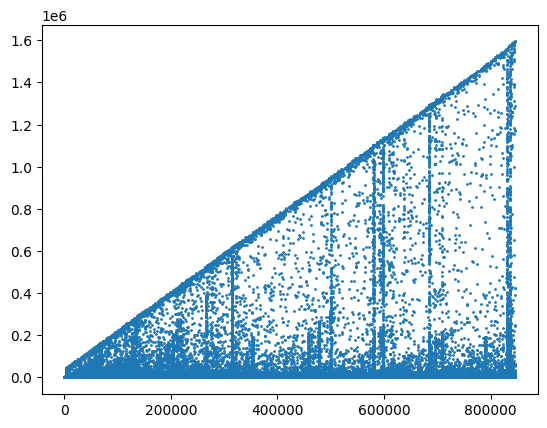

In [8]:
# plot distribution of message distances
# plt.hist(np.concatenate(msg_distances), bins=100)

daily_dist = msg_distances[0]
print("Minimum:", np.min(daily_dist))
print("Maximum:", np.max(daily_dist))

# sort distances
# daily_dist = np.sort(daily_dist)

# plot scatter plot of message distances
plt.scatter(range(len(daily_dist)), daily_dist, s=1)


# plot histogram of message distances
# plt.hist(daily_dist, bins=20)

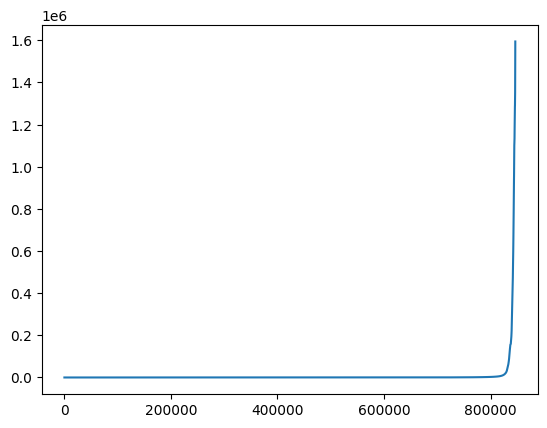

In [9]:
# sort distances
sorted_dist = np.sort(daily_dist)

# plot line plot of sorted message distances
plt.plot(sorted_dist)

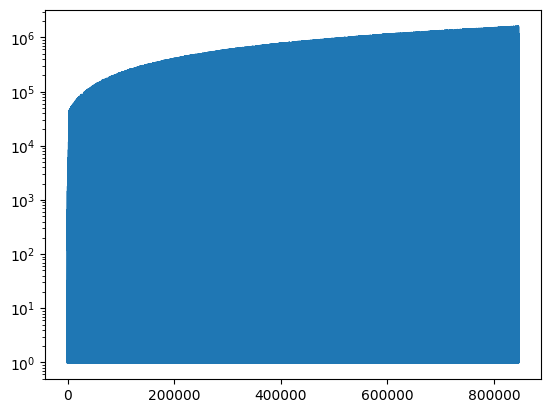

In [10]:
# make a density plot of daily_dist with a log scale y-axis
# plt.hist(daily_dist, bins=20, density=True)
plt.semilogy(range(len(daily_dist)), daily_dist)
# plt.semilogy(sorted_dist)

In [11]:
pct = 0.8
pct_region = int(len(sorted_dist) * pct // 1)
sorted_dist[0:pct_region]

array([  1,   1,   1, ..., 284, 284, 284])

In [12]:
# sort distances
sorted_dist = np.sort(np.concatenate(msg_distances))

# pct_range = np.linspace(0.5,0.9,5)
pct_range = np.linspace(0.5,0.9,9)
for pct in pct_range:
    pct_region = int(len(sorted_dist) * pct // 1)
    print(f"{int(pct*100)}%: {np.max(sorted_dist[0:pct_region])}, block size: {np.max(sorted_dist[0:pct_region])*24}")

50%: 37, block size: 888
55%: 47, block size: 1128
60%: 61, block size: 1464
65%: 81, block size: 1944
70%: 110, block size: 2640
75%: 153, block size: 3672
80%: 223, block size: 5352
85%: 352, block size: 8448
90%: 661, block size: 15864


#### How many messages per sec? (As function of time of day)

In [13]:
nano_sec_per_sec = int(1e9)
nano_sec_per_hour = 60 * 60 * nano_sec_per_sec

market_open_time = int(9.5 * nano_sec_per_hour) # 9:30 AM
market_close_time = int(16 * nano_sec_per_hour) # 4:00 PM
print("Market open time:", market_open_time)
print("Market close time:", market_close_time)

market_hours = market_close_time - market_open_time
print("Nanoseconds per market day::", market_hours)

sec_per_market_day = int(market_hours / nano_sec_per_sec)
print("Seconds per market day:", sec_per_market_day)

market_sec_intervals = np.arange(market_open_time, market_close_time+nano_sec_per_sec, nano_sec_per_sec)
assert len(market_sec_intervals) == sec_per_market_day + 1

Market open time: 34200000000000
Market close time: 57600000000000
Nanoseconds per market day:: 23400000000000
Seconds per market day: 23400


In [14]:
np.arange(market_open_time, market_close_time+nano_sec_per_sec, nano_sec_per_sec)

array([34200000000000, 34201000000000, 34202000000000, ...,
       57598000000000, 57599000000000, 57600000000000])

In [16]:
df = messages_list[0]

# locate rows in df that are within the market_sec_intervals bucket
len(df.loc[df['time'].between(market_sec_intervals[0], market_sec_intervals[1])])

653

In [83]:
msg_interval_list = []
for i in range(len(messages_list)):
    df = messages_list[i]
    date, sym = data_id_list[i]
    print(f"Date: {date}, Symbol: {sym}")

    msg_per_interval = []
    for i in range(len(market_sec_intervals)-1):
        num_msgs_in_bucket = len(df.loc[df['time'].between(market_sec_intervals[i], market_sec_intervals[i+1])])
        msg_per_interval.append(num_msgs_in_bucket)

    assert len(msg_per_interval) == sec_per_market_day

    # plot bar graph of messages per second
    sorted_intervals = np.sort(msg_per_interval)
    print("5 smallest msg intervals:", sorted_intervals[:5])
    print("5 biggest msg intervals:", sorted_intervals[-5:])
    print("Min messages per second:", np.min(msg_per_interval))
    print("Max messages per second:", np.max(msg_per_interval))
    # plt.bar(range(len(msg_per_interval)), msg_per_interval)
    time_axis = range(int(market_open_time / nano_sec_per_sec), int(market_close_time / nano_sec_per_sec))
    plt.bar(time_axis, msg_per_interval)

    plt.xlabel("Time")
    plt.ylabel("Number of Messages")

    time_mesh = np.arange(
        int(str_to_ns("09:30:00") / nano_sec_per_sec),
        int(str_to_ns("16:00:00") / nano_sec_per_sec),
        60*30 # last number is minutes increment (every 30 minutes in this case)
    )
    _=plt.xticks(time_mesh, [ pd.Timestamp(time, unit="s").strftime("%Y-%m-%d %H:%M:%S").split(" ")[1] for time in time_mesh], rotation=60 )

    # save figure and append to list
    plt.savefig(f'{parent_folder_path}/fig/{date}_{sym}_msg_buckets.png', bbox_inches='tight')
    plt.close()
    msg_interval_list.append(msg_per_interval)

Date: 01302019, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 0]
5 biggest msg intervals: [ 2681  3244  4597  9473 16628]
Min messages per second: 0
Max messages per second: 16628
Date: 01302020, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 1]
5 biggest msg intervals: [2296 3054 3706 4429 7188]
Min messages per second: 0
Max messages per second: 7188
Date: 03272019, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 1]
5 biggest msg intervals: [2125 3649 4630 8341 8920]
Min messages per second: 0
Max messages per second: 8920
Date: 07302019, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 0]
5 biggest msg intervals: [2136 2642 2727 6581 9218]
Min messages per second: 0
Max messages per second: 9218
Date: 08302019, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 0]
5 biggest msg intervals: [2888 3116 5647 7207 9757]
Min messages per second: 0
Max messages per second: 9757
Date: 10302019, Symbol: AAPL
5 smallest msg intervals: [0 0 0 0 0]
5 biggest msg intervals: [2053 2483 3342 4037 7

In [87]:
msg_interval_list

for msg_interval in msg_interval_list:
    print("Median message/sec over trading day:", int(np.median(msg_interval)))

# median message/sec over first 30 min of trading day
for msg_interval in msg_interval_list:
    print("Median message/sec over first 30 min of trading day:", int(np.median(msg_interval[:(30*60)])))

Median message/sec over trading day: 51
Median message/sec over trading day: 67
Median message/sec over trading day: 68
Median message/sec over trading day: 37
Median message/sec over trading day: 35
Median message/sec over trading day: 21
Median message/sec over trading day: 44
Median message/sec over trading day: 45
Median message/sec over first 30 min of trading day: 121
Median message/sec over first 30 min of trading day: 114
Median message/sec over first 30 min of trading day: 121
Median message/sec over first 30 min of trading day: 70
Median message/sec over first 30 min of trading day: 41
Median message/sec over first 30 min of trading day: 39
Median message/sec over first 30 min of trading day: 103
Median message/sec over first 30 min of trading day: 120
